Installing libraries and cloning github repository

In [ ]:
!git clone https://github.com/FutureComputing4AI/EMBER2024.git
%cd EMBER2024
!pip install .
!pip install scikit-learn joblib

import os

#Creation of all necessary folders
data_dir = "/content/EMBER2024/data"
os.makedirs(data_dir, exist_ok=True)

import thrember

#Downloading training/test/challenge set for PDFs
print("Downloading train...")
thrember.download_dataset(data_dir, file_type="PDF", split="train")

print("Downloading test...")
thrember.download_dataset(data_dir, file_type="PDF", split="test")

#Challenge set downloaded but not used (it contains all file types)
print("Downloading challenge...")
thrember.download_dataset(data_dir, split="challenge")

thrember.create_vectorized_features(data_dir)

X_train, y_train = thrember.read_vectorized_features(data_dir, subset="train")
X_test, y_test = thrember.read_vectorized_features(data_dir, subset="test")
X_challenge, y_challenge = thrember.read_vectorized_features(data_dir, subset="challenge")


fatal: destination path 'EMBER2024' already exists and is not an empty directory.
/content/EMBER2024
Processing /content/EMBER2024
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for thrember: filename=thrember-0.1.0-py3-none-any.whl size=26781 sha256=c15cd1c00ad4b34c2cd93fe38cf6f6281b39505f53ce84f38b18719bb4d8d1b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-6vtmful0/wheels/21/ee/ca/911b4783aa75e217485919f249cb705350c3244fd7894fbb21
Successfully built thrember
  Attempting uninstall: thrember
    Found existing installation: thrember 0.1.0
    Uninstalling thrember-0.1.0:
      Successfully uninstalled thrember-0.1.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


PDF_train.zip:   0%|          | 0.00/123M [00:00<?, ?B/s]

Unzipping...


PDF_test.zip:   0%|          | 0.00/28.8M [00:00<?, ?B/s]

Unzipping...


challenge.zip:   0%|          | 0.00/32.1M [00:00<?, ?B/s]

Preparing to vectorize raw features
Vectorizing training set


100%|██████████| 104000/104000 [02:21<00:00, 737.47it/s]


Vectorizing test set


100%|██████████| 24000/24000 [00:32<00:00, 744.06it/s]


Vectorizing challenge set


100%|██████████| 6315/6315 [00:16<00:00, 378.64it/s]


Scaling data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

Discarding duplicates

In [ ]:
import numpy as np

# Discarding duplicates
# 'unique_X_test' will contain unique rows
# 'unique_test_indices' will contain indices of unique rows
unique_X_train, unique_train_indices = np.unique(scaled_X_train, axis=0, return_index=True)
unique_X_test, unique_test_indices = np.unique(scaled_X_test, axis=0, return_index=True)

# Indices are used for extracting the corresponding labels from y_test
unique_y_train = y_train[unique_train_indices]
unique_y_test = y_test[unique_test_indices]

# Size check
print(f"Dimensioni di unique_X_train: {unique_X_train.shape}")
print(f"Dimensioni di unique_y_train: {unique_y_train.shape}")

print(f"Dimensioni di unique_X_test: {unique_X_test.shape}")
print(f"Dimensioni di unique_y_test: {unique_y_test.shape}")

print(f"Train samples totali: {len(unique_y_train)}")
print(f"Train malicious: {sum(unique_y_train == 1)}")
print(f"Train benign: {sum(unique_y_train == 0)}")

print(f"Test samples totali: {len(unique_y_test)}")
print(f"Test malicious: {sum(unique_y_test == 1)}")
print(f"Test benign: {sum(unique_y_test == 0)}")

print(f"Challenge samples totali: {len(y_challenge)}")
print(f"Challenge malicious: {sum(y_challenge == 1)}")
print(f"Challenge benign: {sum(y_challenge == 0)}")

Dimensioni di unique_X_train: (52000, 2568)
Dimensioni di unique_y_train: (52000,)
Dimensioni di unique_X_test: (12000, 2568)
Dimensioni di unique_y_test: (12000,)
Train samples totali: 52000
Train malicious: 26000
Train benign: 26000
Test samples totali: 12000
Test malicious: 6000
Test benign: 6000
Challenge samples totali: 6315
Challenge malicious: 6315
Challenge benign: 0


Model LightGBM (with parameters proposed by the authors of the paper)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

# Model definition
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    num_leaves=64,
    min_child_samples=100
)

print("Training LightGBM...")
lgb_model.fit(unique_X_train, unique_y_train)

# Prediction on the set without duplicates
lgb_proba = lgb_model.predict_proba(unique_X_test)[:, 1]
lgb_pred  = lgb_model.predict(unique_X_test)

print("Metrics...")
print(f"ROC-AUC:  {roc_auc_score(unique_y_test, lgb_proba):.4f}")
print(f"PR-AUC:   {average_precision_score(unique_y_test, lgb_proba):.4f}")
print(f"Accuracy: {((lgb_pred == unique_y_test).mean()):.4f}")


Training LightGBM...
[LightGBM] [Info] Number of positive: 26000, number of negative: 26000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.831360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 159800
[LightGBM] [Info] Number of data points in the train set: 52000, number of used features: 664
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Metriche...
ROC-AUC:  0.9911
PR-AUC:   0.9932
Accuracy: 0.9590


RandomForest Classifier: finding best hyperparameters with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5],
}
clf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

print("Training...")
clf.fit(unique_X_train, unique_y_train)

print("Predicting...")
ypred = clf.predict(unique_X_test)

# Results
print("- Best parameters set found on development set:", clf.best_params_)
print("- Grid scores on development set:")

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("        %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))


Training


RF model definition with the best hyperparameters given by GridSearchCV

Metrics...
ROC-AUC:  0.9854
PR-AUC:   0.9885
Accuracy: 0.9427


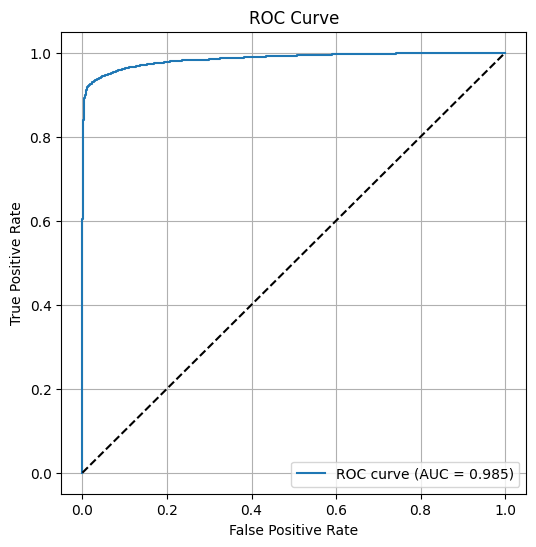

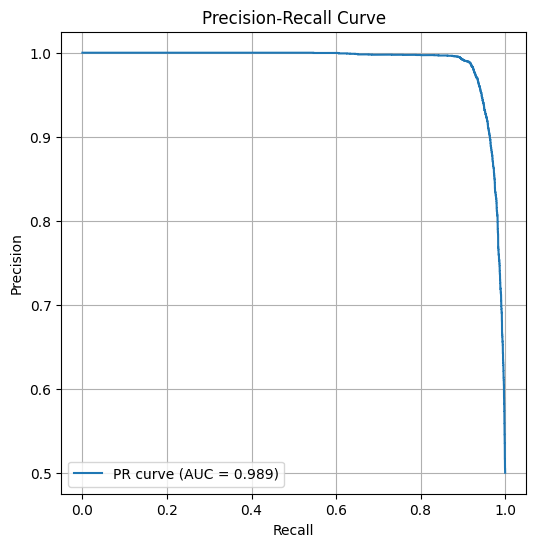

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

# Random Forest already trained
rf_model = RandomForestClassifier(random_state=42,
                               n_jobs=-1,
                               n_estimators= 200,
                               max_depth= 20,
                               max_features= "log2",
                               min_samples_split= 2)

rf_model.fit(unique_X_train, unique_y_train)

rf_proba = rf_model.predict_proba(unique_X_test)[:,1]
rf_pred  = rf_model.predict(unique_X_test)

# RF metrics
print("Metrics...")
print(f"ROC-AUC:  {roc_auc_score(unique_y_test, rf_proba):.4f}")
print(f"PR-AUC:   {average_precision_score(unique_y_test, rf_proba):.4f}")
print(f"Accuracy: {((rf_pred == unique_y_test).mean()):.4f}")


# ROC Curve for RF model
fpr, tpr, _ = roc_curve(unique_y_test, rf_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall Curve for RF model
precision, recall, _ = precision_recall_curve(unique_y_test, rf_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()



LightGBM and RF comparison

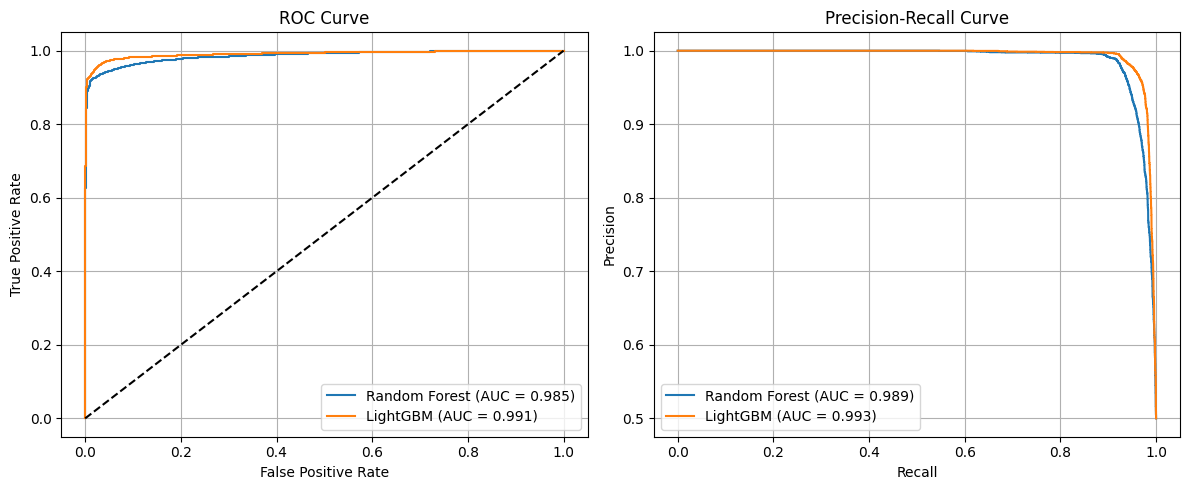

In [ ]:
# ROC: RF vs LGB curves
rf_fpr, rf_tpr, _ = roc_curve(unique_y_test, rf_proba)
lgb_fpr, lgb_tpr, _ = roc_curve(unique_y_test, lgb_proba)

rf_roc_auc = auc(rf_fpr, rf_tpr)
lgb_roc_auc = auc(lgb_fpr, lgb_tpr)

# Precsion-Recall: RF vs LGB curves
rf_prec, rf_rec, _ = precision_recall_curve(unique_y_test, rf_proba)
lgb_prec, lgb_rec, _ = precision_recall_curve(unique_y_test, lgb_proba)

rf_pr_auc = auc(rf_rec, rf_prec)
lgb_pr_auc = auc(lgb_rec, lgb_prec)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC
axes[0].plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_roc_auc:.3f})")
axes[0].plot(lgb_fpr, lgb_tpr, label=f"LightGBM (AUC = {lgb_roc_auc:.3f})")
axes[0].plot([0, 1], [0, 1], "k--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend(loc="lower right")
axes[0].grid(True)

# Precision-Recall
axes[1].plot(rf_rec, rf_prec, label=f"Random Forest (AUC = {rf_pr_auc:.3f})")
axes[1].plot(lgb_rec, lgb_prec, label=f"LightGBM (AUC = {lgb_pr_auc:.3f})")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].legend(loc="lower left")
axes[1].grid(True)

plt.tight_layout()
plt.show()


Computing TPR for FPR=0.01 for RF and LGBM

In [ ]:
import numpy as np

target_fpr = 0.01

# Random Forest
rf_idx = np.argmin(np.abs(rf_fpr - target_fpr))
rf_tpr_at_1 = rf_tpr[rf_idx]

# LightGBM
lgb_idx = np.argmin(np.abs(lgb_fpr - target_fpr))
lgb_tpr_at_1 = lgb_tpr[lgb_idx]

print(f"Random Forest - TPR @ FPR=1%: {rf_tpr_at_1:.3f}")
print(f"LightGBM      - TPR @ FPR=1%: {lgb_tpr_at_1:.3f}")

Random Forest - TPR @ FPR=1%: 0.914
LightGBM      - TPR @ FPR=1%: 0.928
